# Inception v3 model

In [18]:
import numpy as np

#### to make this notebook's output stable across runs

In [15]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Download the latest pretrained Inception v3 model:   
the checkpoint is available at https://github.com/tensorflow/models/tree/master/research/slim.  
The list of class names is available at https://goo.gl/brXRtZ, but you must insert a "background" class at the beginning.

In [2]:
import sys
import tarfile
from six.moves import urllib
import os

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

In [5]:
def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [6]:
fetch_pretrained_inception_v3()

Downloading: 100%

### get class names
n01440764 tench, Tinca tinca  
n01443537 goldfish, Carassius auratus  
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias  

In [9]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [10]:
class_names = ["background"] + load_class_names()

In [13]:
class_names[:5]

['background',
 u'tench, Tinca tinca',
 u'goldfish, Carassius auratus',
 u'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 u'tiger shark, Galeocerdo cuvieri']

### Create the Inception v3 model by calling the inception_v3() function

In [16]:
# tensorflow.contrib.slim provides us many popular cv deep neural networks
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

import tensorflow as tf

In [19]:
reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

In [20]:
end_points

{'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=floa

### restore the pretrained model checkpoint you downloaded earlier

In [21]:
INCEPTION_V3_CHECKPOINT_PATH

'datasets/inception/inception_v3.ckpt'

In [22]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


### play with some downloaded animal images

Resize and/or crop them to 299 × 299 pixels, and ensure that they have just three channels (RGB), with no transparency channel.  
The images that the Inception model was trained on were preprocessed so that their values range from -1.0 to 1.0, so you must ensure that your images do too.  

In [23]:
width = 299
height = 299
channels = 3

In [26]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

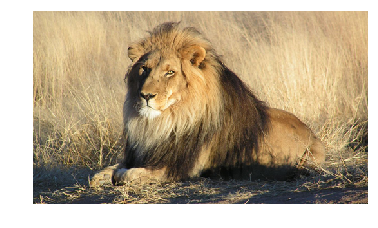

In [111]:
test_image_name = "lion.jpg"
test_image = mpimg.imread(os.path.join("images", test_image_name))
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [127]:
def img_process(img, scale=True):
    length_order = np.argsort(img.size)

    ratio = 299. / img.size[length_order[0]]
    new_short = 299
    new_long = int(ratio * img.size[length_order[1]])

    if length_order[0] == 0:
        new_size = (new_short, new_long)
    else:
        new_size = (new_long, new_short)

    crop_size = (int((new_size[0] - 299) / 2.), int((new_size[1] - 299) / 2.), 
                 new_size[0] - int((new_size[0] - 299) / 2.), new_size[1] - int((new_size[1] - 299) / 2.))
    
    img_out = np.array(img.resize(new_size).crop(crop_size).resize((299, 299)))
    
    if scale:
        img_out = (img_out * 2) / 255. - 1
    
    return img_out

In [113]:
img = Image.open(os.path.join("images", test_image_name))
processed_img = img_process(img)

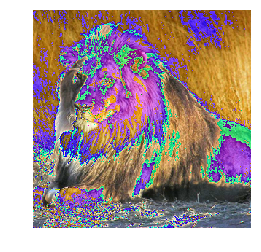

In [114]:
plt.imshow(processed_img)
plt.axis("off")
plt.show()

### try to predict with inception v3

In [115]:
X_test = processed_img.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [116]:
predictions_val

array([[  3.23957502e-04,   9.66836596e-05,   3.70713271e-04, ...,
          2.60109635e-04,   2.84748792e-04,   4.16320283e-04]], dtype=float32)

In [117]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

981

In [118]:
class_names[most_likely_class_index]

u'volcano'

In [119]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

volcano: 12.27%
Arabian camel, dromedary, Camelus dromedarius: 4.40%
ram, tup: 3.78%
llama: 3.75%
quill, quill pen: 2.65%


### show the result in batch

In [123]:
test_image_names = []
for f in os.listdir("images"):
    test_image_names.append(f)
    
test_image_processed = []
for img_name in test_image_names:
    img = Image.open(os.path.join("images", img_name))
    processed_img = img_process(img)  
    test_image_processed.append(processed_img)

test_image_processed = np.array(test_image_processed)

In [124]:
test_image_processed.shape

(4, 299, 299, 3)

In [125]:
X_test_batch = test_image_processed.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test_batch})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [126]:
predictions_val

array([[  1.41089607e-04,   2.13695414e-04,   2.33011000e-04, ...,
          1.45482030e-04,   2.14283136e-04,   2.38159933e-04],
       [  3.23957531e-04,   9.66836233e-05,   3.70713184e-04, ...,
          2.60109548e-04,   2.84748705e-04,   4.16320167e-04],
       [  2.93230667e-04,   2.95752427e-04,   4.83422686e-04, ...,
          4.11258981e-04,   7.73030159e-04,   5.91559568e-04],
       [  6.56294724e-05,   9.60653924e-05,   1.06091291e-04, ...,
          5.26317126e-05,   8.41480796e-05,   1.40706514e-04]], dtype=float32)

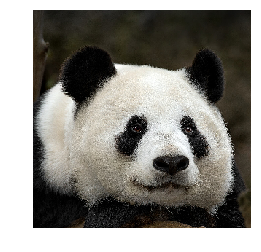

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca: 43.31%
brown bear, bruin, Ursus arctos: 23.54%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 0.68%
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens: 0.63%
American black bear, black bear, Ursus americanus, Euarctos americanus: 0.58%


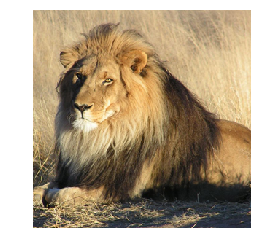

volcano: 12.27%
Arabian camel, dromedary, Camelus dromedarius: 4.40%
ram, tup: 3.78%
llama: 3.75%
quill, quill pen: 2.65%


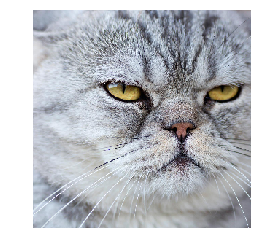

lynx, catamount: 22.78%
tabby, tabby cat: 7.80%
tiger cat: 7.10%
Persian cat: 7.07%
snow leopard, ounce, Panthera uncia: 2.19%


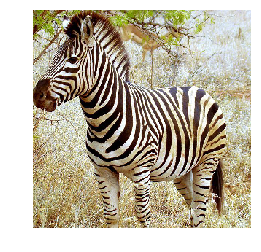

zebra: 88.68%
impala, Aepyceros melampus: 0.21%
hartebeest: 0.18%
ostrich, Struthio camelus: 0.13%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.11%


In [136]:
for img_idx, img_name in enumerate(test_image_names):
    img = Image.open(os.path.join("images", img_name))
    processed_img = img_process(img, False)  
    plt.imshow(processed_img)
    plt.axis("off")
    plt.show()
    
    top_5 = np.argpartition(predictions_val[img_idx], -5)[-5:]
    top_5 = reversed(top_5[np.argsort(predictions_val[img_idx][top_5])])
    for i in top_5:
        print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[img_idx][i]))